# Data Scientist Job Market in the US
### Shanshan Wang

In [2]:
import pandas as pd
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [3]:
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle

## Data Preparation

In [4]:
df = pd.read_csv('alldata.csv')
df.head()

position             company  \
0                               Development Director             ALS TDI   
1  An Ostentatiously-Excitable Principal Research...  The Hexagon Lavish   
2                                     Data Scientist      Xpert Staffing   
3                                       Data Analyst      Operation HOPE   
4  Assistant Professor -TT - Signal Processing & ...    Emory University   

                                         description  reviews  \
0  Development Director\nALS Therapy Development ...      NaN   
1  Job Description\n\n"The road that leads to acc...      NaN   
2  Growing company located in the Atlanta, GA are...      NaN   
3  DEPARTMENT: Program OperationsPOSITION LOCATIO...     44.0   
4  DESCRIPTION\nThe Emory University Department o...    550.0   

             location  
0  Atlanta, GA 30301   
1         Atlanta, GA  
2         Atlanta, GA  
3  Atlanta, GA 30303   
4         Atlanta, GA

In [5]:
df.isnull().sum()

position         11
company          11
description      11
reviews        1638
location         11
dtype: int64

In [6]:
df.drop(columns = 'reviews', inplace = True)

In [7]:
df.drop(index = df[df['position'].isnull()].index, inplace = True)
df.isnull().any()

position       False
company        False
description    False
location       False
dtype: bool

### Create New Columns

Create City and State columns based on the Location column 

In [8]:
# get only the state and city name
df['location'] = df.location.apply(lambda x: re.sub('\d*','',str(x)))
df['city'] = df.location.apply(lambda x: x.split(',')[0].strip())
df['state'] = df.location.apply(lambda x: x.split(',')[1].strip())
df['location'] = df['city']+ ', ' + df['state']
df.head()

position             company  \
0                               Development Director             ALS TDI   
1  An Ostentatiously-Excitable Principal Research...  The Hexagon Lavish   
2                                     Data Scientist      Xpert Staffing   
3                                       Data Analyst      Operation HOPE   
4  Assistant Professor -TT - Signal Processing & ...    Emory University   

                                         description     location     city  \
0  Development Director\nALS Therapy Development ...  Atlanta, GA  Atlanta   
1  Job Description\n\n"The road that leads to acc...  Atlanta, GA  Atlanta   
2  Growing company located in the Atlanta, GA are...  Atlanta, GA  Atlanta   
3  DEPARTMENT: Program OperationsPOSITION LOCATIO...  Atlanta, GA  Atlanta   
4  DESCRIPTION\nThe Emory University Department o...  Atlanta, GA  Atlanta   

  state  
0    GA  
1    GA  
2    GA  
3    GA  
4    GA

## Positions by job title

Reference: https://www.kaggle.com/pramod7/data-science-jobs-opening-in-us-analysis-ml

In [9]:
#there are so many job profiles in the given dataset so lets Categories them into 5; 
# Data Scientist, Machine Learning Engineer, Data Analyst, Data Science Manager and Others
# Creating only 5 datascience roles among all

data = df.copy()

data['position']=[x.upper() for x in data['position']]

data.loc[data.position.str.contains("SCIENTIST"), 'position'] = 'Data Scientist'

data.loc[data.position.str.contains('ENGINEER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('PRINCIPAL STATISTICAL PROGRAMMER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('PROGRAMMER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('DEVELOPER'),'position']='Machine Learning Engineer'

data.loc[data.position.str.contains('ANALYST'), 'position'] = 'Data Analyst'
data.loc[data.position.str.contains('STATISTICIAN'), 'position'] = 'Data Analyst'

data.loc[data.position.str.contains('MANAGER'),'position']='Data Science Manager'
data.loc[data.position.str.contains('CONSULTANT'),'position']='Data Science Manager'
data.loc[data.position.str.contains('DATA SCIENCE'),'position']='Data Science Manager'
data.loc[data.position.str.contains('DIRECTOR'),'position']='Data Science Manager'

data.position=data[(data.position == 'Data Scientist') | (data.position == 'Data Analyst') | (data.position == 'Machine Learning Engineer') | (data.position == 'Data Science Manager')]
data.position=['Others' if x is np.nan else x for x in data.position]

position=data.groupby(['position'])['company'].count()   
position=position.reset_index(name='company')
position=position.sort_values(['company'],ascending=False)
position

position  company
2             Data Scientist     2645
3  Machine Learning Engineer     1384
4                     Others     1295
0               Data Analyst      848
1       Data Science Manager      781

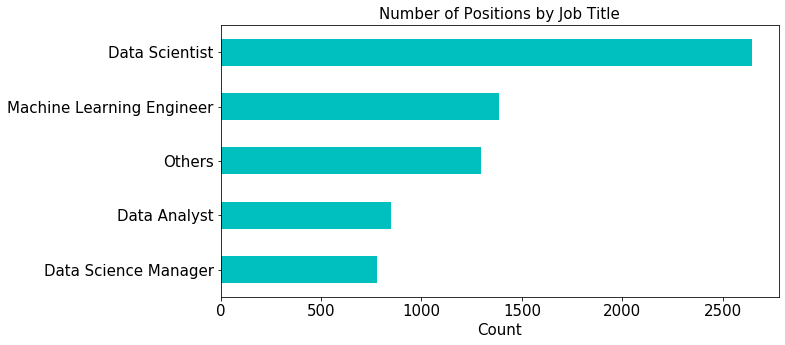

In [10]:
title = data.groupby(['position']).count().sort_values('company')
title['company'].plot(kind='barh',figsize = (10,5), color = 'c')
plt.xlabel('Count', size = 15)
plt.ylabel('')
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.title('Number of Positions by Job Title', size = 15)
plt.show()

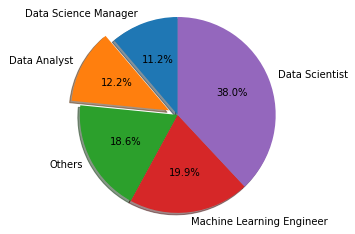

In [11]:
labels = 'Data Science Manager ', 'Data Analyst', 'Others', 'Machine Learning Engineer','Data Scientist'
sizes = title['company']
explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Positions by Company

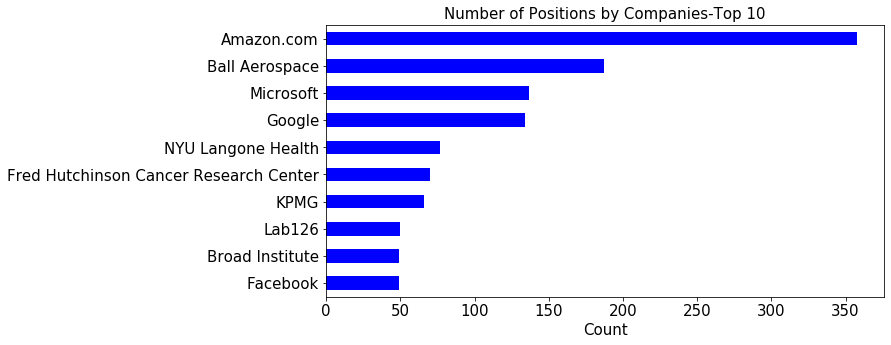

In [12]:
company = df.groupby(['company']).count().sort_values('position').tail(10)

company['position'].plot(kind='barh',figsize = (10,5), color = 'b')
plt.xlabel('Count', size = 15)
plt.ylabel('')
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.title('Number of Positions by Companies-Top 10', size = 15)
plt.show()

## Positions by city

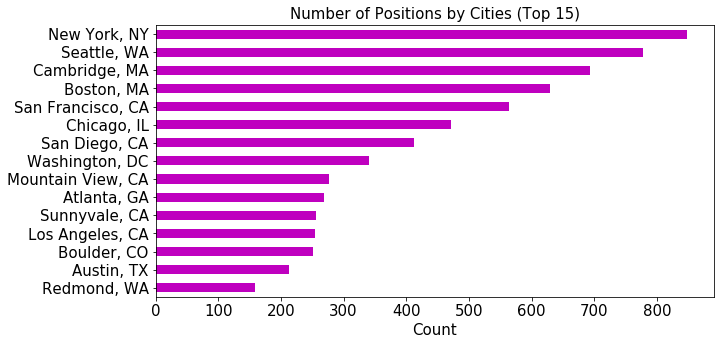

In [13]:
city = df.groupby(['location']).count().sort_values('position').tail(15)

city['position'].plot(kind='barh',figsize = (10,5), color = 'm')
plt.xlabel('Count', size = 15)
plt.ylabel('')
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.title('Number of Positions by Cities (Top 15)', size = 15)
plt.show()

## Positions by state

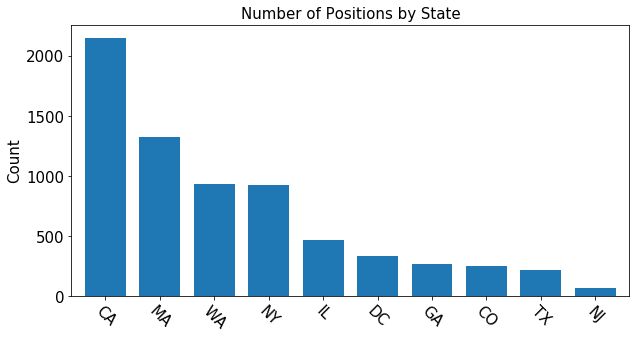

In [14]:
state = df.groupby('state').count().sort_values('position',ascending = False)
state['position'].plot(kind = 'bar',figsize = (10,5) ,width = 0.75)
plt.xlabel('')
plt.ylabel('Count',size = 15)
plt.title('Number of Positions by State', size = 15)
plt.yticks(size = 15)
plt.xticks(size = 15, rotation = -45)
plt.show()

The highest number of position by state is California, follows by Massachusetts and Washington when the city with the highest number of positions is New York.

## Position by state and job title

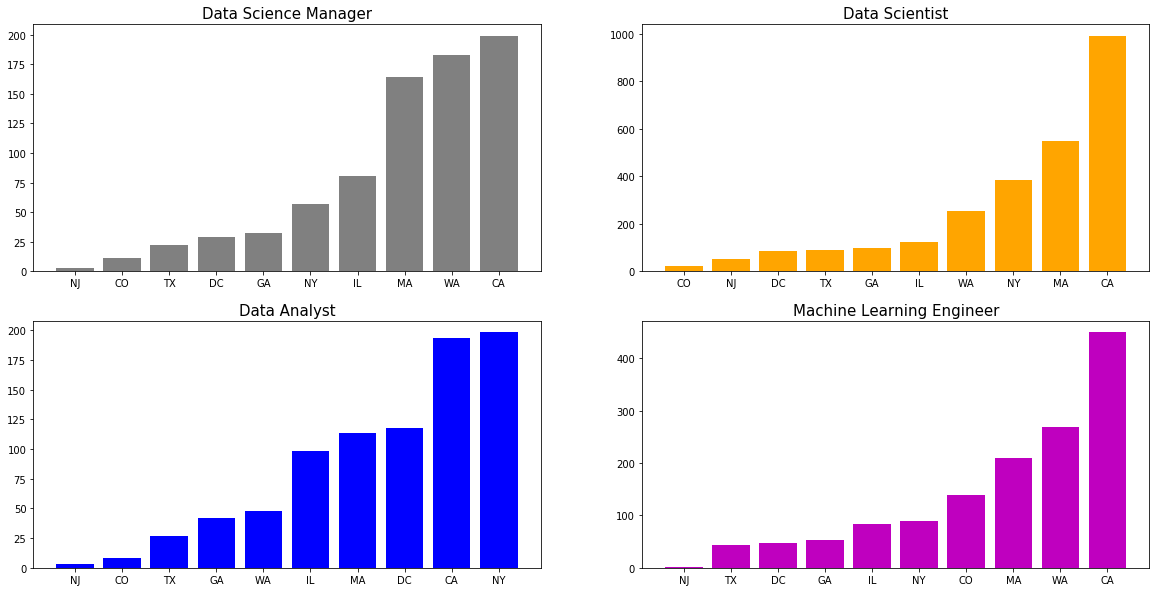

In [15]:
data = data[data['position'] != 'Others']
i = 1
color = ['grey','orange','blue','m']
fig = plt.figure(figsize=(20,10))
for position in data.position.unique():
    x = data[data['position']== str(position)].groupby(['state']).count().sort_values('company')
    plt.subplot(2, 2, i)
    i += 1
    plt.bar(x.index,x['company'], color = color[i-2])
    plt.xlabel('')
    plt.xticks(size = 10)
    plt.title(str(position), size = 15)
plt.show()

## Combine by job tilte

In [16]:
data = data.groupby('position').agg(lambda col: ' '.join(col))
data = data[['description']]
data

description
position                                                                    
Data Analyst               DEPARTMENT: Program OperationsPOSITION LOCATIO...
Data Science Manager       Development Director\nALS Therapy Development ...
Data Scientist             Job Description\n\n"The road that leads to acc...
Machine Learning Engineer  Qualifications\nBachelor’s degree in Computer ...

## Clean text data

In [17]:
def clean_text(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text).lower() 
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n',' ',text)
    return text

clean = lambda x :clean_text(x)

df_clean = pd.DataFrame(data.description.apply(clean))

#remove the part with job title 'Others' 
df_clean = df_clean[df_clean.index != 'Others'].copy()

# split the sentence and lemmatize the text data
lemmer = WordNetLemmatizer()
df_clean['description'] = df_clean.description.apply(lambda x: word_tokenize(x))
df_clean['description'] = df_clean.description.apply(lambda x : [lemmer.lemmatize(y) for y in x])
df_clean['description'] = df_clean.description.apply(lambda x: ' '.join(x))

# combine words frequently appear in the description in the stop words
extra_stopword = ['experience','work','team','will','skill','skills','year','data']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stopword)

## WordCloud

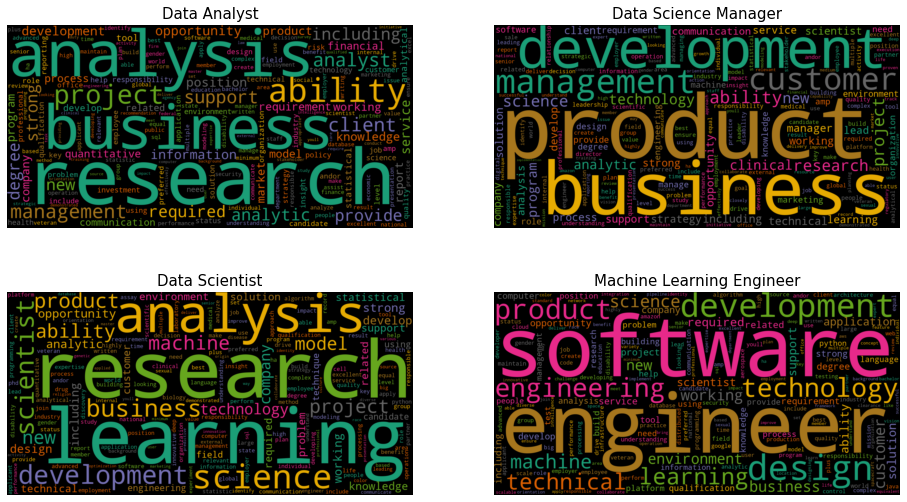

In [18]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="black", colormap="Dark2",
             random_state=42, collocations = False, width=1600, height=800)
i = 0

fig = plt.figure(figsize=(16,9))

for x in df_clean.description.index:
    wc.generate(df_clean.description[str(x)])
    i += 1
    fig.add_subplot(2, 2, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(str(x), size = 15)
plt.show()

In [19]:
text = df.description.values

## Get the year value

In [22]:
# add the year value into a list
# remove year values which are above 18
experience_req = []
for t in text:
    for sentance in t.split('\n'):
        if 'experience' in sentance:
            year = re.findall("\d{1,2}\+? year", sentance)
            if len(year)==1:
                num = year[0].split(' ')
                experience_req.append(num[0])
                
for n,i in enumerate(experience_req):
    if "+" in i:
        experience_req[n] = re.sub(r'\+','',i)
experience_req = [int(item) for item in experience_req]
                  
for n,i in enumerate(experience_req):
    if i >= 18:
        experience_req.pop(n)

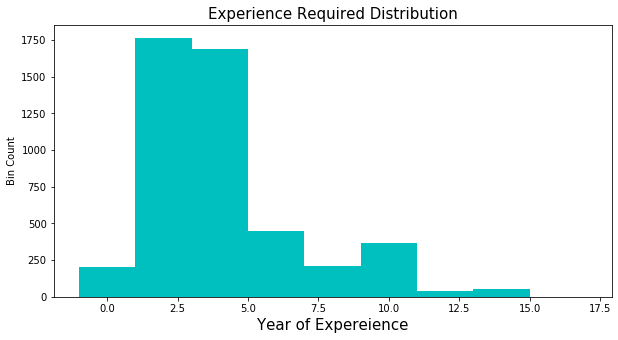

In [23]:
plt.figure(figsize = (10,5))
plt.hist(experience_req,bins = list(range(0,20,2)), align = 'left', color='c')
plt.title('Experience Required Distribution', size = 15)
plt.ylabel('Bin Count')
plt.xlabel('Year of Expereience', size = 15)
plt.show()

In [25]:
# average year
round(np.mean(experience_req),2)

4.67

## Degree

In [34]:
# count the number of PhD and master
pattern = re.compile('(?i)\WPh.?D\W')
pattern2 = re.compile('(?i)\WDoctorate\W')
count = 0
for t in text:
    if pattern.search(t):
        count +=1
    elif pattern2.search(t):
        count +=1
degree = {"PhD": count}


pattern = re.compile("(?i)\WMasters?'?s?\W")
pattern2 = re.compile('(?i)\WM.?S\W')
count = 0
for t in text:
    if pattern.search(t):
        count +=1
    elif pattern2.search(t):
        count +=1
degree.update({"Master":count})

In [35]:
# calculate the percentage

degree = pd.DataFrame.from_dict(degree,orient='index',
                       columns=[ 'count'])
degree['percentage'] = degree['count']/len(text)

degree

count  percentage
PhD      2639    0.379548
Master   3290    0.473177

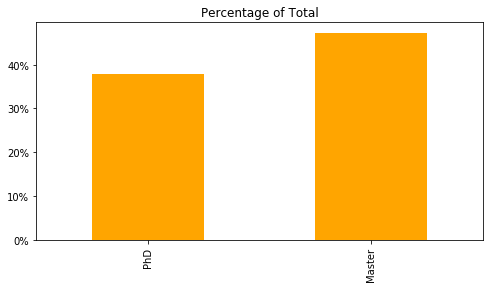

In [37]:
ax =degree['percentage'].plot(kind = "bar", figsize =(8,4), color = 'orange')
ax.set_title('Percentage of Total')
ax.set_xticklabels(degree.index)
ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
plt.show()

## Skills needed for finding a job

In [38]:
# regex search
def count_text(patt,text):
    pattern = re.compile(patt)
    count = 0
    for t in text:
        if pattern.search(t):
            count+=1
    return count

In [43]:
skills = ['R','Python','Spark','SQL','Tableau','TensorFlow','Agile','Algorithm','Java','Visualization']
skill_patt = ['\WR\W+\s*','(?i)\WPython\W','(?i)\WSpark\W?','(?i)SQL\w*','(?i)\WTableau\W?',
              "(?i)\WTensorFlow\W?","(?i)\WAgile\W?","(?i)\WAlgorithms?\W?",'(?i)Java\w*','(?i)\WVisualization\W?']

skill_df =pd.DataFrame({"skill": skills, "regex_pattern":skill_patt})

i = []
for x in skill_df['regex_pattern']:
    i.append(count_text(x,text))
skill_df['count'] = i
skill_df['percentage'] = round(skill_df['count']/len(text),2)
skill_df

skill           regex_pattern  count  percentage
0              R               \WR\W+\s*   2187        0.31
1         Python          (?i)\WPython\W   2822        0.41
2          Spark          (?i)\WSpark\W?    986        0.14
3            SQL              (?i)SQL\w*   1924        0.28
4        Tableau        (?i)\WTableau\W?    492        0.07
5     TensorFlow     (?i)\WTensorFlow\W?    406        0.06
6          Agile          (?i)\WAgile\W?    698        0.10
7      Algorithm    (?i)\WAlgorithms?\W?   1703        0.24
8           Java             (?i)Java\w*   1397        0.20
9  Visualization  (?i)\WVisualization\W?   1015        0.15

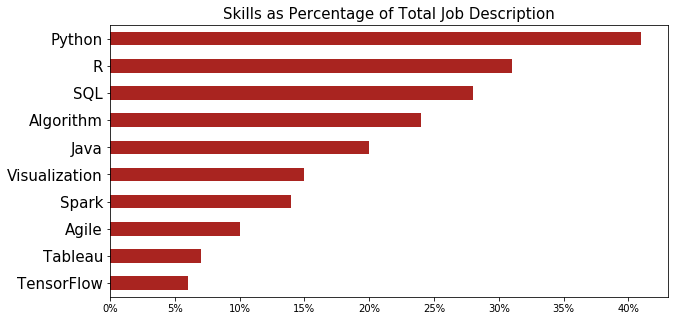

In [45]:
x = skill_df.sort_values(by = 'percentage')
ax =x['percentage'].plot(kind = "barh",figsize = (10,5), color = '#A92420')
ax.set_title('Skills as Percentage of Total Job Description', size = 15)
ax.set_yticklabels(x['skill'], size = 15)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
plt.show()

## Use word frequencies to classify job position types

In [46]:
data = df.copy()
data['position']=[x.upper() for x in data['position']]
data.loc[data.position.str.contains("SCIENTIST"), 'position'] = 'Data Scientist'

data.loc[data.position.str.contains('ENGINEER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('PRINCIPAL STATISTICAL PROGRAMMER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('PROGRAMMER'),'position']='Machine Learning Engineer'
data.loc[data.position.str.contains('DEVELOPER'),'position']='Machine Learning Engineer'

data.loc[data.position.str.contains('ANALYST'), 'position'] = 'Data Analyst'
data.loc[data.position.str.contains('STATISTICIAN'), 'position'] = 'Data Analyst'

data.loc[data.position.str.contains('MANAGER'),'position']='Data Science Manager'
data.loc[data.position.str.contains('CONSULTANT'),'position']='Data Science Manager'
data.loc[data.position.str.contains('DATA SCIENCE'),'position']='Data Science Manager'
data.loc[data.position.str.contains('DIRECTOR'),'position']='Data Science Manager'

data.position=data[(data.position == 'Data Scientist') | (data.position == 'Data Analyst') | (data.position == 'Machine Learning Engineer') | (data.position == 'Data Science Manager')]
data.position=['Others' if x is np.nan else x for x in data.position]


In [47]:
data

position                           company  \
0          Data Science Manager                           ALS TDI   
1                Data Scientist                The Hexagon Lavish   
2                Data Scientist                    Xpert Staffing   
3                  Data Analyst                    Operation HOPE   
4                        Others                  Emory University   
...                         ...                               ...   
6959  Machine Learning Engineer                            NetApp   
6960             Data Scientist  Pharmacyclics, an Abbvie Company   
6961             Data Scientist                          Oath Inc   
6962             Data Scientist                         Microsoft   
6963             Data Scientist                           Comcast   

                                            description       location  \
0     Development Director\nALS Therapy Development ...    Atlanta, GA   
1     Job Description\n\n"The road that leads to acc...    Atlanta, GA   
2     Growing company located in the Atlanta, GA are...    Atlanta, GA   
3     DEPARTMENT: Program OperationsPOSITION LOCATIO...    Atlanta, GA   
4     DESCRIPTION\nThe Emory University Department o...    Atlanta, GA   
...                                                 ...            ...   
6959  Are you data-driven? We at NetApp believe in t...  Sunnyvale, CA   
6960  Pharmacyclics is committed to the development ...  Sunnyvale, CA   
6961  Oath, a subsidiary of Verizon, is a values-led...  Sunnyvale, CA   
6962  We are the Bing Core Relevance team responsibl...  Sunnyvale, CA   
6963  Comcast’s Technology &amp; Product organizatio...  Sunnyvale, CA   

           city state  
0       Atlanta    GA  
1       Atlanta    GA  
2       Atlanta    GA  
3       Atlanta    GA  
4       Atlanta    GA  
...         ...   ...  
6959  Sunnyvale    CA  
6960  Sunnyvale    CA  
6961  Sunnyvale    CA  
6962  Sunnyvale    CA  
6963  Sunnyvale    CA  

[6953 rows x 6 columns]

In [48]:
# input are description and output are the type of position

X=data.description
Y=data.position

#  Data Cleansing
X=[re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in X]
X=[re.sub("[0-9]+",' ',k) for k in X]

#applying stemmer
ps =PorterStemmer()
X=[ps.stem(k) for k in X]

tfidf=TfidfVectorizer()
label_enc=LabelEncoder()

X=tfidf.fit_transform(X)
Y=label_enc.fit_transform(Y)

# training dataset 70% test dataset 30%
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3)

In [49]:
# SGD classification
sgd=SGDClassifier()
sgd.fit(x_train,y_train)
sgd_y=sgd.predict(x_test)

print('Accuracy of SGD :', accuracy_score(y_test,sgd_y))
print ('Confusion Matrix of SGD : ', '\n\n', confusion_matrix(y_test,sgd_y))

#crossfold Validation of 5 folds for SGD
cross_val_SGD=sklearn.model_selection.cross_validate(sgd, x_train, y=y_train,cv=5)

Accuracy of SGD : 0.7746883988494727
Confusion Matrix of SGD :  

 [[193   1  26   7  17]
 [ 12 136  42  18  30]
 [ 23  12 691  38  41]
 [  9   6  41 363  16]
 [ 15  22  65  29 233]]
